In [1]:
import collections
from collections import namedtuple
import bs4
import requests
import logging
import csv
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import statsmodels.formula.api as smf

# Часть 1 - Сбор данных

In [2]:
#логгирование
logging.basicConfig(level=logging.DEBUG)
logger=logging.getLogger('cian')

#для помещения результатов
ParseResult=collections.namedtuple(
    'ParseResult', ('title', 'adress', 'price','price_M2'))

#заголовок csv файла
HEADERS=('title','adress', 'price','price_M2')


#парсер
class CianParser:
    
#чтобы зайти как браузер
    def __init__(self):
        self.session = requests.Session()
        self.session.headers = {
            #рандомное
            'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 11_2_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.90 Safari/537.36',
            'Accept-Language':"ru",
        }
        self.result=[]

#залезаем на страничку циан
    def get_page(self, page: int= None): 
        page = str(page)
        url='https://www.cian.ru/cat.php?deal_type=sale&engine_version=2&offer_type=flat&p='+page+'&region=1'
        r=self.session.get(url=url)
        r.raise_for_status()
        return r.text
    
    def get_blocks(self):
        text=self.get_page(page=2)
        soup=bs4.BeautifulSoup(text,'lxml')
        container=soup.select('article._93444fe79c--container--2pFUD._93444fe79c--cont--1Ddh2')
        for block in container:
            self.parse_block(block=block)


#выгружаем html в виде текста
    def parse_page(self, text:str):
        soup=bs4.BeautifulSoup(text,'lxml')
        container=soup.select('article._93444fe79c--container--2pFUD._93444fe79c--cont--1Ddh2')
        for block in container:
            self.parse_block(block=block)
       
 #парсим по блокам
    def parse_block(self, block):
    
#парсим title 
        title_block=block.select_one('div._93444fe79c--container--JdWD4')
        title = title_block.select_one('span._93444fe79c--color_black_100--A_xYw._93444fe79c--lineHeight_28px--3QLml._93444fe79c--fontWeight_bold--t3Ars._93444fe79c--fontSize_22px--3UVPd._93444fe79c--display_block--1eYsq._93444fe79c--text--2_SER')
        title=title_block.text
        
#парсим adress
        adress_block=block.select_one('div._93444fe79c--labels--1J6M3')
        adress=adress_block.select('a._93444fe79c--link--10mjQ')
        
#парсим price
        
        price = block.select('span._93444fe79c--color_black_100--A_xYw._93444fe79c--lineHeight_28px--3QLml._93444fe79c--fontWeight_bold--t3Ars._93444fe79c--fontSize_22px--3UVPd._93444fe79c--display_block--1eYsq._93444fe79c--text--2_SER')
        price_M2 = block.select('p._93444fe79c--color_gray60_100--3VLtJ._93444fe79c--lineHeight_20px--2dV2a._93444fe79c--fontWeight_normal--2G6_P._93444fe79c--fontSize_14px--10R7l._93444fe79c--display_block--1eYsq._93444fe79c--text--2_SER')
#выводим результаты
        self.result.append(ParseResult(
             title=title,
             adress=adress, 
             price=price, 
             price_M2=price_M2))      
       
 #сохраняем csv
    def save_result(self):
        path = 'cian.csv'
        with open(path,'w') as f:
            writer =csv.writer(f, quoting=csv.QUOTE_MINIMAL)
            writer.writerow(HEADERS)
            for item in self.result:
                writer.writerow(item)

            
    def run(self):
        for page in range(1,54): #там 54 страницы на дату выполения проекта, если количество страниц изменится: скрипт может упасть
            text = self.get_page(page)
            self.parse_page(text=text)
            logger.info(f'Страница {page}, Получили {len(self.result)} элементов')
            self.save_result()

            
if __name__=='__main__':
    parser=CianParser()
    parser.run()
    

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): www.cian.ru:443
DEBUG:urllib3.connectionpool:https://www.cian.ru:443 "GET /cat.php?deal_type=sale&engine_version=2&offer_type=flat&p=1&region=1 HTTP/1.1" 200 None
INFO:cian:Страница 1, Получили 28 элементов
DEBUG:urllib3.connectionpool:https://www.cian.ru:443 "GET /cat.php?deal_type=sale&engine_version=2&offer_type=flat&p=2&region=1 HTTP/1.1" 200 None
INFO:cian:Страница 2, Получили 56 элементов
DEBUG:urllib3.connectionpool:https://www.cian.ru:443 "GET /cat.php?deal_type=sale&engine_version=2&offer_type=flat&p=3&region=1 HTTP/1.1" 200 None
INFO:cian:Страница 3, Получили 84 элементов
DEBUG:urllib3.connectionpool:https://www.cian.ru:443 "GET /cat.php?deal_type=sale&engine_version=2&offer_type=flat&p=4&region=1 HTTP/1.1" 200 None
INFO:cian:Страница 4, Получили 112 элементов
DEBUG:urllib3.connectionpool:https://www.cian.ru:443 "GET /cat.php?deal_type=sale&engine_version=2&offer_type=flat&p=5&region=1 HTTP/1.1" 200 None
INFO:cia

DEBUG:urllib3.connectionpool:https://www.cian.ru:443 "GET /cat.php?deal_type=sale&engine_version=2&offer_type=flat&p=43&region=1 HTTP/1.1" 200 None
INFO:cian:Страница 43, Получили 1204 элементов
DEBUG:urllib3.connectionpool:https://www.cian.ru:443 "GET /cat.php?deal_type=sale&engine_version=2&offer_type=flat&p=44&region=1 HTTP/1.1" 200 None
INFO:cian:Страница 44, Получили 1232 элементов
DEBUG:urllib3.connectionpool:https://www.cian.ru:443 "GET /cat.php?deal_type=sale&engine_version=2&offer_type=flat&p=45&region=1 HTTP/1.1" 200 None
INFO:cian:Страница 45, Получили 1260 элементов
DEBUG:urllib3.connectionpool:https://www.cian.ru:443 "GET /cat.php?deal_type=sale&engine_version=2&offer_type=flat&p=46&region=1 HTTP/1.1" 200 None
INFO:cian:Страница 46, Получили 1288 элементов
DEBUG:urllib3.connectionpool:https://www.cian.ru:443 "GET /cat.php?deal_type=sale&engine_version=2&offer_type=flat&p=47&region=1 HTTP/1.1" 200 None
INFO:cian:Страница 47, Получили 1316 элементов
DEBUG:urllib3.connectionp

In [3]:
df=pd.read_csv("cian.csv",header=0, error_bad_lines=False, sep=',')
df

,title,adress,price,price_M2
0,"Выдача ключей в декабре 20203-комн. апарт., 94...","[<a class=""_93444fe79c--link--10mjQ"" data-name...","[<span class=""_93444fe79c--color_black_100--A_...","[<p class=""_93444fe79c--color_gray60_100--3VLt..."
1,"ЖК Hyatt Regency Moscow3-комн. апарт., 146 м²,...","[<a class=""_93444fe79c--link--10mjQ"" data-name...","[<span class=""_93444fe79c--color_black_100--A_...","[<p class=""_93444fe79c--color_gray60_100--3VLt..."
2,"3-комн. апарт., 94 м², 3/20 этаж","[<a class=""_93444fe79c--link--10mjQ"" data-name...","[<span class=""_93444fe79c--color_black_100--A_...","[<p class=""_93444fe79c--color_gray60_100--3VLt..."
3,"Отличное предложение на Якиманке4-комн. кв., 1...","[<a class=""_93444fe79c--link--10mjQ"" data-name...","[<span class=""_93444fe79c--color_black_100--A_...","[<p class=""_93444fe79c--color_gray60_100--3VLt..."
4,"Апартаменты-студия, 53,9 м², 74/96 этаж","[<a class=""_93444fe79c--link--10mjQ"" data-name...","[<span class=""_93444fe79c--color_black_100--A_...","[<p class=""_93444fe79c--color_gray60_100--3VLt..."
5,"Лучшая квартира в готовом доме!1-комн. кв., 66...","[<a class=""_93444fe79c--link--10mjQ"" data-name...","[<span class=""_93444fe79c--color_black_100--A_...","[<p class=""_93444fe79c--color_gray60_100--3VLt..."
6,"3-комн. кв., 100,6 м², 2/28 этаж","[<a class=""_93444fe79c--link--10mjQ"" data-name...","[<span class=""_93444fe79c--color_black_100--A_...","[<p class=""_93444fe79c--color_gray60_100--3VLt..."
7,"2-комн. кв., 109,3 м², 53/58 этаж","[<a class=""_93444fe79c--link--10mjQ"" data-name...","[<span class=""_93444fe79c--color_black_100--A_...","[<p class=""_93444fe79c--color_gray60_100--3VLt..."
8,"1-комн. апарт., 60,2 м², 13/26 этаж","[<a class=""_93444fe79c--link--10mjQ"" data-name...","[<span class=""_93444fe79c--color_black_100--A_...","[<p class=""_93444fe79c--color_gray60_100--3VLt..."
9,"3-комн. апарт., 123,8 м², 14/15 этаж","[<a class=""_93444fe79c--link--10mjQ"" data-name...","[<span class=""_93444fe79c--color_black_100--A_...","[<p class=""_93444fe79c--color_gray60_100--3VLt..."


# Часть 2- Чистка данных

In [4]:
df['city'] = 1
df['AO'] = 1
df['district'] = 1
df['metro'] = 1
df['street'] = 1
df['house'] = 1

In [5]:
for iter in range(len(df)):
    df['city'][iter] = re.split(r'>',re.split(r'</a>',df['adress'][iter])[0])[1]
    df['AO'][iter] = re.split(r'>',re.split(r'</a>',df['adress'][iter])[1])[1]
    df['district'][iter] = re.split(r'>',re.split(r'</a>',df['adress'][iter])[2])[1]
    df['metro'][iter] = re.split(r'>',re.split(r'</a>',df['adress'][iter])[3])[1]
    df['street'][iter] = re.split(r'>',re.split(r'</a>',df['adress'][iter])[4])[1]
    if '<a class=' in re.split(r'</a>',df['adress'][iter])[5]:
        df['house'][iter] = re.split(r'>',re.split(r'</a>',df['adress'][iter])[5])[1]
    else:
        df['house'][iter] = ' '      

/Users/nailya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/nailya/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/nailya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports

In [6]:
df.head(5)

,title,adress,price,price_M2,city,AO,district,metro,street,house
0,"Выдача ключей в декабре 20203-комн. апарт., 94...","[<a class=""_93444fe79c--link--10mjQ"" data-name...","[<span class=""_93444fe79c--color_black_100--A_...","[<p class=""_93444fe79c--color_gray60_100--3VLt...",Москва,САО,р-н Беговой,м. Белорусская,Бумажный проезд,2/2С6
1,"ЖК Hyatt Regency Moscow3-комн. апарт., 146 м²,...","[<a class=""_93444fe79c--link--10mjQ"" data-name...","[<span class=""_93444fe79c--color_black_100--A_...","[<p class=""_93444fe79c--color_gray60_100--3VLt...",Москва,САО,р-н Аэропорт,м. Динамо,Ленинградский проспект,36с31
2,"3-комн. апарт., 94 м², 3/20 этаж","[<a class=""_93444fe79c--link--10mjQ"" data-name...","[<span class=""_93444fe79c--color_black_100--A_...","[<p class=""_93444fe79c--color_gray60_100--3VLt...",Москва,САО,р-н Беговой,м. Белорусская,Бумажный проезд,2/2
3,"Отличное предложение на Якиманке4-комн. кв., 1...","[<a class=""_93444fe79c--link--10mjQ"" data-name...","[<span class=""_93444fe79c--color_black_100--A_...","[<p class=""_93444fe79c--color_gray60_100--3VLt...",Москва,ЦАО,р-н Якиманка,м. Полянка,улица Малая Полянка,2
4,"Апартаменты-студия, 53,9 м², 74/96 этаж","[<a class=""_93444fe79c--link--10mjQ"" data-name...","[<span class=""_93444fe79c--color_black_100--A_...","[<p class=""_93444fe79c--color_gray60_100--3VLt...",Москва,ЦАО,р-н Пресненский,м. Международная,набережная Пресненская,12


In [7]:
df['price'] = df['price'].str.replace('<span class="_93444fe79c--color_black_100--A_xYw _93444fe79c--lineHeight_28px--3QLml _93444fe79c--fontWeight_bold--t3Ars _93444fe79c--fontSize_22px--3UVPd _93444fe79c--display_block--1eYsq _93444fe79c--text--2_SER' ,'')
df['price'] = df['price'].str.replace('data-mark="OfferTitle" style="letter-spacing:normal"','')
df['price'] = df['price'].str.replace(r"[a-z]",'')
df['price'] = df['price'].str.replace(r'^.*?MP','')
df['price'] = df['price'].str.replace(r"\W",'')
df['price_M2'] = df['price_M2'].str.replace('p class="_93444fe79c--color_gray60_100--3VLtJ _93444fe79c--lineHeight_20px--2dV2a _93444fe79c--fontWeight_normal--2G6_P _93444fe79c--fontSize_14px--10R7l _93444fe79c--display_block--1eYsq _93444fe79c--text--2_SER" data-mark="PriceInfo" style="letter-spacing:normal">','')
df['price_M2'] = df['price_M2'].str.replace(r"\W",'')
df['price_M2'] = df['price_M2'].str.replace("м²p",'')

df.drop('adress',axis=1, inplace=True)

df.head(5)

,title,price,price_M2,city,AO,district,metro,street,house
0,"Выдача ключей в декабре 20203-комн. апарт., 94...",30900000,328723,Москва,САО,р-н Беговой,м. Белорусская,Бумажный проезд,2/2С6
1,"ЖК Hyatt Regency Moscow3-комн. апарт., 146 м²,...",89060000,610000,Москва,САО,р-н Аэропорт,м. Динамо,Ленинградский проспект,36с31
2,"3-комн. апарт., 94 м², 3/20 этаж",29966269,318790,Москва,САО,р-н Беговой,м. Белорусская,Бумажный проезд,2/2
3,"Отличное предложение на Якиманке4-комн. кв., 1...",125000000,738771,Москва,ЦАО,р-н Якиманка,м. Полянка,улица Малая Полянка,2
4,"Апартаменты-студия, 53,9 м², 74/96 этаж",36202860,671667,Москва,ЦАО,р-н Пресненский,м. Международная,набережная Пресненская,12


In [8]:
df['flat'] = np.where(df['title'].str.contains("апарт", case=False, na=False), 'no', 'yes')
df= pd.get_dummies(df,columns=['flat'])
df.head(5)

,title,price,price_M2,city,AO,district,metro,street,house,flat_no,flat_yes
0,"Выдача ключей в декабре 20203-комн. апарт., 94...",30900000,328723,Москва,САО,р-н Беговой,м. Белорусская,Бумажный проезд,2/2С6,1,0
1,"ЖК Hyatt Regency Moscow3-комн. апарт., 146 м²,...",89060000,610000,Москва,САО,р-н Аэропорт,м. Динамо,Ленинградский проспект,36с31,1,0
2,"3-комн. апарт., 94 м², 3/20 этаж",29966269,318790,Москва,САО,р-н Беговой,м. Белорусская,Бумажный проезд,2/2,1,0
3,"Отличное предложение на Якиманке4-комн. кв., 1...",125000000,738771,Москва,ЦАО,р-н Якиманка,м. Полянка,улица Малая Полянка,2,0,1
4,"Апартаменты-студия, 53,9 м², 74/96 этаж",36202860,671667,Москва,ЦАО,р-н Пресненский,м. Международная,набережная Пресненская,12,1,0


In [9]:
df_1 = pd.DataFrame(df.title.str.split('-комн',1).tolist(),
                                 columns = ['room_count','title_2'])

df_1['room_count'] = df_1['room_count'].str[-1:]
df_1['room_count'] = df_1['room_count'].str.replace(r"[^0-9.,]+",'')
df_1.room_count = df_1.room_count.replace({"":np.nan})
df_1.drop('title_2',axis=1, inplace=True)

df_1

,room_count
0,3
1,3
2,3
3,4
4,NaN
5,1
6,3
7,2
8,1
9,3


In [10]:
df_floor = pd.DataFrame(df.title.str.split('этаж',1).tolist(),
                                 columns = ['flat_floor','house_total_floor'])
df_floor['flat_floor'] = df_floor['flat_floor'].str[-6:]
df_floor = pd.DataFrame(df_floor.flat_floor.str.split('/',1).tolist(),
                                 columns = ['flat_floor','house_total_floor'])


df_floor['flat_floor'] = df_floor['flat_floor'].str.replace(r"\D",'')
df_floor.flat_floor = df_floor.flat_floor.replace({"":np.nan})
df_floor.house_total_floor = df_floor.house_total_floor.replace({"":np.nan})

df_floor

,flat_floor,house_total_floor
0,15,21
1,6,10
2,3,20
3,3,11
4,74,96
5,4,11
6,2,28
7,53,58
8,13,26
9,14,15


In [11]:
df_3 = pd.concat([df, df_1,df_floor], axis=1)
df_3.drop('title',axis=1, inplace=True)
df_3.drop('city',axis=1, inplace=True)
df_3.drop('flat_no',axis=1, inplace=True)

df_3 = df_3.dropna() 

df_3.head(5)

,price,price_M2,AO,district,metro,street,house,flat_yes,room_count,flat_floor,house_total_floor
0,30900000,328723,САО,р-н Беговой,м. Белорусская,Бумажный проезд,2/2С6,0,3,15,21
1,89060000,610000,САО,р-н Аэропорт,м. Динамо,Ленинградский проспект,36с31,0,3,6,10
2,29966269,318790,САО,р-н Беговой,м. Белорусская,Бумажный проезд,2/2,0,3,3,20
3,125000000,738771,ЦАО,р-н Якиманка,м. Полянка,улица Малая Полянка,2,1,4,3,11
5,39000000,590015,ЦАО,р-н Хамовники,м. Спортивная,улица Ефремова,10с1к4/5,1,1,4,11


In [12]:
df_3.dtypes

price                object
price_M2             object
AO                   object
district             object
metro                object
street               object
house                object
flat_yes              uint8
room_count           object
flat_floor           object
house_total_floor    object
dtype: object

In [13]:
df_3["price"]=df_3['price'].astype(int)
df_3["price_M2"]=df_3['price_M2'].astype(int)
df_3["flat_floor"]=df_3['flat_floor'].astype(int)
df_3["house_total_floor"]=df_3['house_total_floor'].astype(int)
df_3["room_count"]=df_3['room_count'].astype(int)
df_3["flat_yes"]=df_3['flat_yes'].astype(int)

#вводим переменную location, которая показывает удаленность от центра АО, 
                                                    #где 1- это центр,например ЦАО, а 4-это окраина (ЗелАО)
df_3["location"]=2
df_3["location"][df_3['AO'].str.contains("ЦАО")] = "1"
df_3["location"][df_3['AO'].str.contains("НАО (Новомосковский)")] = "3"
df_3["location"][df_3['AO'].str.contains("ЗелАО")] = "4"
df_3["location"]=df_3['location'].astype(int)

#вычисляем сколько квадратных метров в квартире
df_3['M2']=df_3['price']/df_3["price_M2"]

#итоговая таблица
df_3

/Users/nailya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/nailya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if sys.path[0] == '':
/Users/nailya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/nailya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of

,price,price_M2,AO,district,metro,street,house,flat_yes,room_count,flat_floor,house_total_floor,location,M2
0,30900000,328723,САО,р-н Беговой,м. Белорусская,Бумажный проезд,2/2С6,0,3,15,21,2,94.000116
1,89060000,610000,САО,р-н Аэропорт,м. Динамо,Ленинградский проспект,36с31,0,3,6,10,2,146.000000
2,29966269,318790,САО,р-н Беговой,м. Белорусская,Бумажный проезд,2/2,0,3,3,20,2,94.000028
3,125000000,738771,ЦАО,р-н Якиманка,м. Полянка,улица Малая Полянка,2,1,4,3,11,1,169.199928
5,39000000,590015,ЦАО,р-н Хамовники,м. Спортивная,улица Ефремова,10с1к4/5,1,1,4,11,1,66.100014
6,30192675,300126,ЗАО,р-н Раменки,м. Раменки,Винницкая улица,8,1,3,2,28,2,100.599998
7,24701800,226000,СВАО,р-н Ростокино,м. Ботанический сад,проспект Мира,188Бк1,1,2,53,58,2,109.300000
8,36603105,608025,ЦАО,р-н Арбат,м. Арбатская,улица Новый Арбат,15,0,1,13,26,1,60.200000
9,38047048,307327,САО,р-н Аэропорт,м. Динамо,Ленинградский проспект,36С10,0,3,14,15,2,123.799887
10,49999000,467280,ЦАО,р-н Мещанский,м. Проспект Мира,Протопоповский переулок,6,1,3,13,14,1,107.000086


# Часть 3 - Численное программирование - регрессия

In [14]:
model = smf.ols('np.log(price) ~  room_count +location + flat_yes +flat_floor + house_total_floor  + M2',data=df_3).fit() 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     766.6
Date:                Tue, 01 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:29:11   Log-Likelihood:                -889.06
No. Observations:                1429   AIC:                             1792.
Df Residuals:                    1422   BIC:                             1829.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            17.4834      0.05

# Часть 4 - Визуализация

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.MaxNLocator object at 0x1a525e3668>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.MaxNLocator object at 0x1a525e3668>
DEBUG:matplotlib.colorbar:Setting pcolormesh


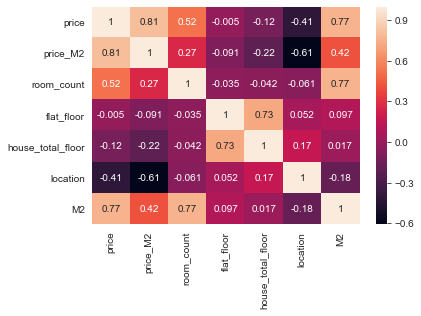

In [23]:
#heatmap - correlation
df_corr=df_3.drop('AO',axis=1).drop('district',axis=1).drop('metro',axis=1).drop('street',axis=1).drop('house',axis=1).drop('flat_yes',axis=1)
sns.heatmap(df_corr.corr(),annot=True) 


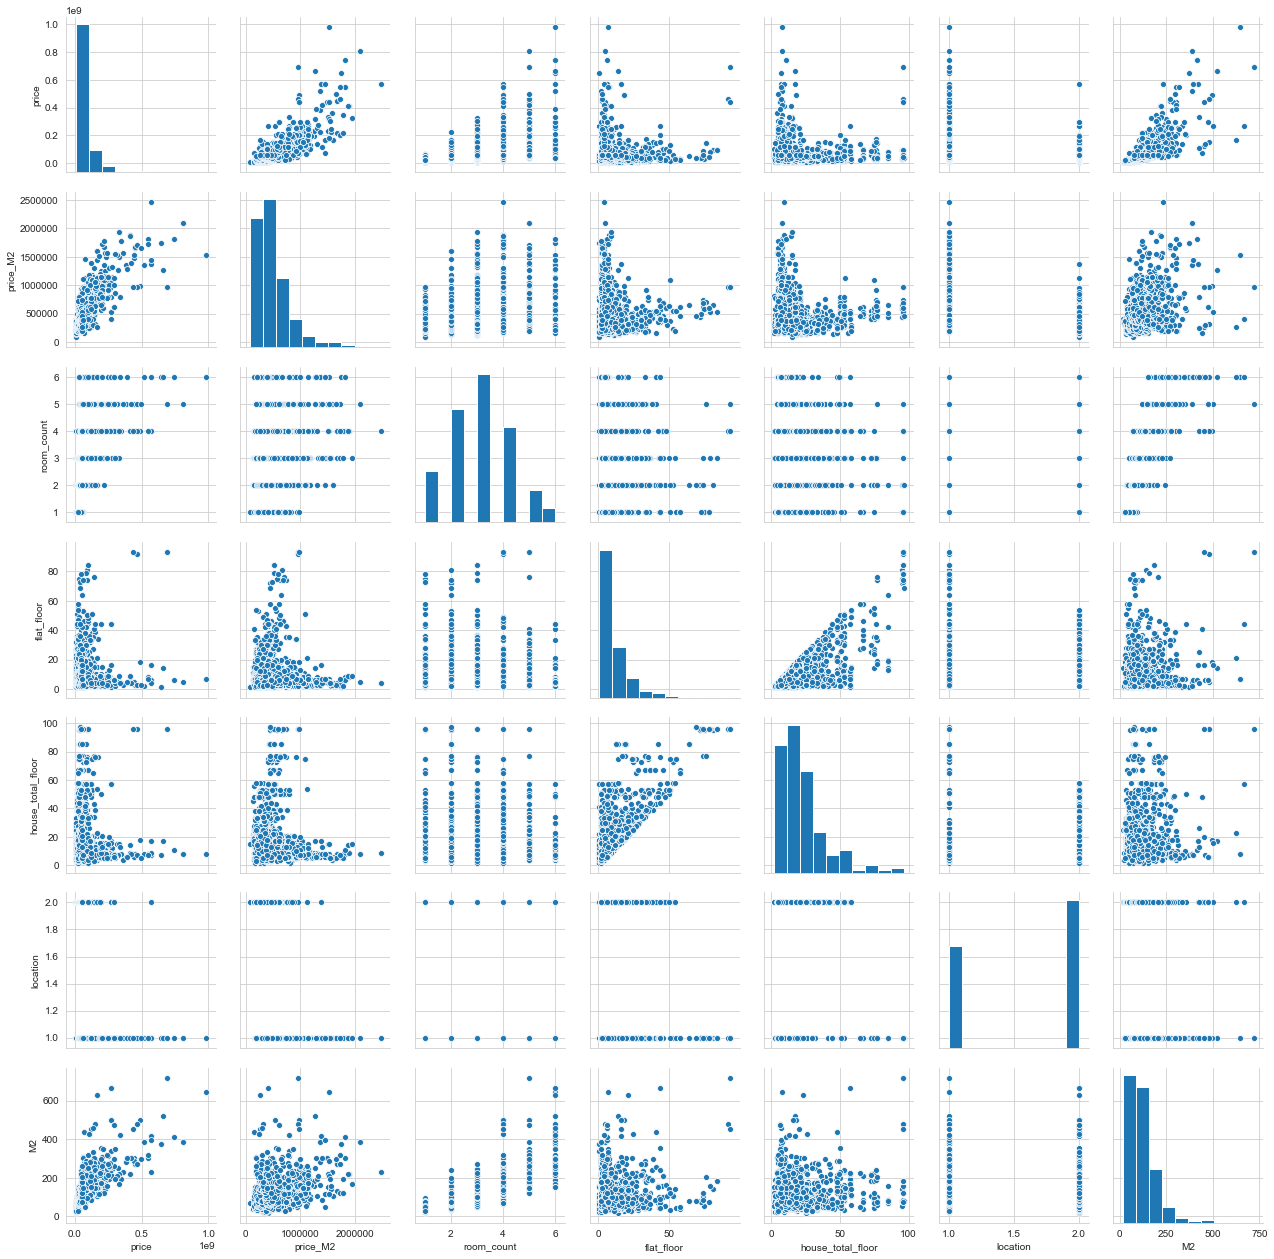

In [16]:
sns.pairplot(df_corr.dropna())

In [17]:
df_mean_3=df_3.groupby('AO')['price_M2'].mean().to_frame()
df_mean_4=df_mean_3.reset_index()
df_mean_4

,AO,price_M2
0,ВАО,260175.800000
1,ЗАО,403417.404255
2,НАО (Новомосковский),169849.263158
3,САО,352585.965986
4,СВАО,232859.500000
5,СЗАО,330234.160000
6,ТАО (Троицкий),180000.000000
7,ЦАО,722979.378007
8,ЮАО,307209.507937
9,ЮВАО,230540.212121


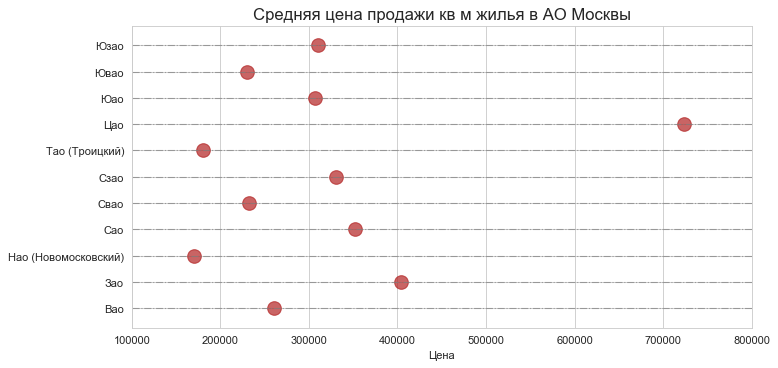

In [22]:
fig, ax = plt.subplots(figsize=(10,5), dpi= 80)
ax.hlines(y=df_mean_4['AO'], xmin=100000, xmax=800000, color='gray', alpha=0.7, linewidth=1, linestyles='dashdot')
ax.scatter(y=df_mean_4['AO'], x=df_mean_4['price_M2'], s=150, color='firebrick', alpha=0.7)


ax.set_title('Средняя цена продажи кв м жилья в АО Москвы', fontdict={'size':15})
ax.set_xlabel('Цена')
ax.set_yticks(df_mean_4['AO'])
ax.set_yticklabels(df_mean_4['AO'].str.title(), fontdict={'horizontalalignment': 'right'})
ax.set_xlim(100000, 800000)

#plt.savefig('pic_5.png')
plt.show()

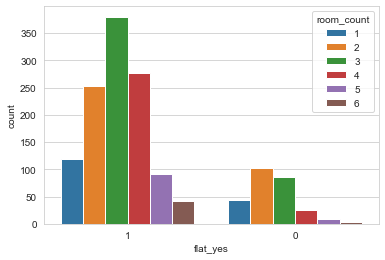

In [19]:
sns.countplot(x='flat_yes',data=df_3, order = df_3['flat_yes'].value_counts().index, hue='room_count')

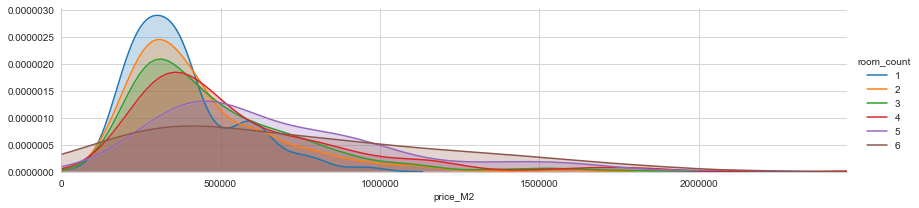

In [20]:
fig = sns.FacetGrid(df_3, hue="room_count",aspect=4)

fig.map(sns.kdeplot,'price_M2',shade= True)

biggest = df_3['price_M2'].max()

fig.set(xlim=(0,biggest))

fig.add_legend()

In [21]:
#df.to_csv('cianPriceInfo.csv', sep=';', index=False, encoding='utf-8-sig')